# Análise de Dados Exploratória da ANAC

![ANAC](imgs/anac-logo.png "Logo ANAC")

# 1. Introdução

Este estudo tem como objetivo analisar um conjunto de dados de voos internacionais registrados pela Agência Nacional de Aviação Civil (ANAC) do Brasil, durante o período de janeiro de 2015 a agosto de 2017. 

A ANAC é a agência reguladora responsável pela aviação civil no país, e as informações contidas nesses dados são de grande importância para a compreensão da dinâmica da aviação internacional no Brasil, bem como para a tomada de decisões estratégicas no setor. O conjunto de dados inclui informações como o número do voo, nome da companhia aérea, horários de partida e chegada previstos e reais, situação do voo e localização dos aeroportos de origem e destino, entre outros. Esses dados permitem uma análise detalhada das tendências e padrões de voos internacionais no Brasil, bem como a identificação de fatores que possam influenciar o desempenho da aviação internacional no país.

## 1.1. Objetivos

O objetivo deste estudo é realizar uma Análise Exploratória dos Dados (Exploratory Data Analysis - EDA) do conjunto de dados disposto em [bases/](bases/), e analisar dados de voos internacionais rastreados pela ANAC.

Com base nas informações disponíveis, pretendemos avaliar o desempenho das companhias aéreas em relação ao cumprimento dos horários previstos de partida e chegada, bem como investigar a frequência de cancelamentos e as justificativas apresentadas para esses casos. 

Também vamos examinar as rotas mais utilizadas e os destinos mais comuns para os voos internacionais saindo do Brasil, bem como avaliar a pontualidade e a eficiência dos aeroportos de origem e destino. 

1. [3.1. Qual destino mais procurado nas férias? (julho, dezembro e janeiro)](#)
1. [3.1.1. Principais destinos regionais](#)
1. [3.1.2. Principais destinos nacionais](#)
1. [3.1.3. Principais destinos internacionais](#)
1. [3.2. Como ficam os aeroportos nesses meses?](#)
1. [3.2.1. Atrasos](#)
1. [3.2.2. Cancelamentos](#)
1. [3.2.1. Atrasos](#)
1. [3.3. Qual a melhor opção uma viagem nacional ou internacional?](#)
1. [3.4. Qual a melhor rota?](#)
1. [3.5. Qual melhor dia da semana para pegar um vôo?](#)


# 2. Metodologia

Nesta seção será apresentado todo o processo de preparação, organização e limpeza de dados feito no *dataset* que possui os seguintes dados brutos. Ao final desta, apresentaremos os dados padronizados e devidamente tratados:

|        Coluna        | Tipo |                         Descrição                         |
|:--------------------:|:----:|:---------------------------------------------------------:|
|         Voos         |  str |                       Número do voo                       |
|    Companhia.Aerea   |  str |                  Nome da companhia aérea                  |
|   Codigo.Tipo.Linha  |  str |          Código do tipo de linha (internacional)          |
|   Partida.Prevista   |  str |                Horário previsto de partida                |
|     Partida.Real     |  str |                  Horário real de partida                  |
|   Chegada.Prevista   |  str |                Horário previsto de chegada                |
|     Chegada.Real     |  str |                  Horário real de chegada                  |
|     Situacao.Voo     |  str |        Situação do voo (realizado, cancelado, etc)        |
| Codigo.Justificativa |  str | Código de justificativa (caso o voo tenha sido cancelado) |
|   Aeroporto.Origem   |  str |               Código do aeroporto de origem               |
|     Cidade.Origem    |  str |                      Cidade de origem                     |
|     Estado.Origem    |  str |                      Estado de origem                     |
|      Pais.Origem     |  str |                       País de origem                      |
|   Aeroporto.Destino  |  str |               Código do aeroporto de destino              |
|    Cidade.Destino    |  str |                     Cidade de destino                     |
|    Estado.Destino    |  str |                     Estado de destino                     |
|     Pais.Destino     |  str |                      País de destino                      |
|       LongDest       |  str |             Longitude do aeroporto de destino             |
|        LatDest       |  str |              Latitude do aeroporto de destino             |
|       LongOrig       |  str |              Longitude do aeroporto de origem             |
|        LatOrig       |  str |              Latitude do aeroporto de origem              |


## 2.1. Configuração do Ambiente

### 2.1.1. Bibliotecas e Ferramentas Necessárias (Built-ins)

1. ```os```:       Para manipular os arquivos de base e seus respectivos diretórios de forma multiplataforma e eficiente.
2. ```re```:       Utilizado em expressões regulares durante o processo de limpeza dos dados.
3. ```enum```:     Auxilia nos processos de padronizar e regular algumas convenções do projeto.
4. ```datetime```, ```time```: Auxilia nos processos de padronizar e regular algumas convenções do projeto.
4. ```typing```: definir tipos em documentações e assinaturas.

### 2.1.2. Bibliotecas e Ferramentas Necessárias (pip)

1. Pandas: Para manipular e exibir os dados de forma coesa e relata.   
    ```pip install pandas```       
    ```import pandas as pd```

2. JinJa2: Complemento de estilização do Pandas.   
    ```pip install Jinja2```

4. Utils: Contém uma série de métodos auxiliares nos processos de organização, limpeza e feature engineering.     
    ```from libs.utils import Utils```

5. Plot: Contém os métodos e regras de negócio para plotar os gráficos.     
    ```from libs.utils import Plot```

5. AnacVoos: Contém Responsável por armazenar,controlar e servir os dados.     
    ```from libs.utils import AnacVoos```

### 2.1.3. Demais bibliotecas em ```libs.utils```:

  
1.    **enum**:               ```from enum import Enum```     

1.    **datetime**:           ```from datetime import datetime```     

1.    **typing**:             ```from typing import Any, Callable, List, Dict, Tuple```     

1.    **numpy**:              ```import numpy```     

1.    **matplotlib.pyplot**:  ```import matplotlib.pyplot```     

1.    **mplcyberpunk**:       ```pip install mplcyberpunk``` | ```import mplcyberpunk```  |

### 2.1.4. Importações gerais para o projeto

In [1]:
import os
import re
import time
import pandas as pd
from libs.utils import Utils, Plot, AnacVoos

## 2.2. Carregamento da base

In [2]:
caminho = os.path.join(
    os.path.dirname(
        os.path.abspath(
            os.path.join(__name__, '.'))), 'bases')

arquivos = [arquivo for arquivo in os.listdir(
    caminho) if arquivo.endswith(".csv")]

dataframes = [pd.read_csv(os.path.join(caminho, arquivo))
              for arquivo in arquivos]

AnacVoos.dados = pd.concat(dataframes)
AnacVoos.total_arquivos = len(arquivos)
AnacVoos.dados_solidos = False
AnacVoos.total_registros = len(AnacVoos.dados.index)
AnacVoos.tempo_execucao = time.time()

## 2.3. Organização e Limpeza dos Dados

### 2.3.1. Padrozinação dos nomes das colunas

In [3]:
nomes_colunas_tratadas = []

for coluna in AnacVoos.dados.columns:
    if any(char.isupper() for char in coluna):
        if coluna == 'Voos':
            coluna = 'Num.Voo'
        nomes_colunas_tratadas.append('_'.join(word.lower() for word in re.findall(
            '[A-Z][^A-Z]*', coluna)).lower().replace('.', ''))

AnacVoos.dados.columns = nomes_colunas_tratadas

### 2.3.2. Padrozinação dos tipos das colunas de data/hora, string e númericos

In [4]:
for coluna in AnacVoos.dados.columns:
    tipo = Utils.tipo_coluna(coluna)
    if tipo.__name__ == 'datetime':
        AnacVoos.dados = Utils.formatar_colunas_datetime(
            AnacVoos.dados, coluna)

### 2.3.3. Padrozinação no nome das companhias aérea.

In [5]:
AnacVoos.dados['companhia_aerea'] = AnacVoos.dados.apply(
    lambda row: Utils.nome_companhia_aerea_normalizado(
        row['companhia_aerea'],
    ), axis=1)

### 2.3.4. Padrozinação dos tipos de linhas: `Nacional`, `Internacional`.

In [7]:
AnacVoos.dados['codigo_tipo_linha'] = AnacVoos.dados.apply(
    lambda row: Utils.tipo_linha_normalizado(
        row['codigo_tipo_linha'],
    ), axis=1)


### 2.3.4. Feature Engineering
A engenharia de recursos (*Feature Engineering*) é o processo de usar o conhecimento do domínio para extrair recursos dos dados brutos. Neste estudo serão acrescentadas as seguintes colunas para enriquecer a análise de dados:

| Coluna         | Descrição                                                            | Base         |
|:--------------:|:--------------------------------------------------------------------:|:--------------:|
| partida_atrasou | Houve atraso na partida (S/N)                                       | `partida_prevista - partida_real` |
| chegada_atrasou | Houve atraso na chegada (S/N)                                       | `chegada_prevista - chegada_real` |
| distancia_km   | Distância total em kms da origem ao destino                          | `lat_long_orig - lat_long_dest` |
| justificativa_atraso   | Informação e correlata à justificativa no atraso do voo      | `codigo_justificativa` |
| justificativa_cancelamento   | Informação e correlata à justificativa do cancelamento do voo| `codigo_justificativa` |
| rota           | Origem x Destino                                                     | `x_origem + x_destino` |
| periodo_ferias           | Contém o mês condizente a um período de férias (Janeiro, Julho ou Dezembro)    | `partida_prevista` **in** [1, 7, 12]  |
| dia_semana           | Contém o dia da semana para data de partida    | `partida_prevista`  |
| tempo_atraso_partida           | Contém o tempo total do atraso na partida  | `partida_prevista` - `partida_real`  |
| tempo_atraso_chegada           | Contém o tempo total do atraso na chegada    | `chegada_prevista` - `chegada_real`  |

#### 2.3.3.1. Atraso na partida

In [8]:
AnacVoos.dados['partida_atrasou'] = AnacVoos.dados.apply(
    lambda row: Utils.validar_atraso(
        row['situacao_voo'],
        row['partida_prevista'],
        row['partida_real']
    ), axis=1)

##### 2.3.3.1.1 Cálculo tempo de atraso na partida

In [9]:
AnacVoos.dados['tempo_atraso_partida'] = AnacVoos.dados.apply(
    lambda row: Utils.calcular_atraso(
        row['partida_atrasou'],
        row['partida_prevista'],
        row['partida_real']
    ), axis=1)

#### 2.3.3.2. Atraso na chegada

In [10]:
AnacVoos.dados['chegada_atrasou'] = AnacVoos.dados.apply(
    lambda row: Utils.validar_atraso(
        row['situacao_voo'],
        row['chegada_prevista'],
        row['chegada_real']
    ), axis=1)

##### 2.3.3.2.1. Cálculo tempo de atraso na chegada

In [11]:
AnacVoos.dados['tempo_atraso_chegada'] = AnacVoos.dados.apply(
    lambda row: Utils.calcular_atraso(
        row['chegada_atrasou'],
        row['chegada_prevista'],
        row['chegada_real']
    ), axis=1)

##### 2.3.3.2.3. Contextualizando campo situação do voo

In [12]:
AnacVoos.dados['situacao_voo'] = AnacVoos.dados.apply(
    lambda row: Utils.atualizar_situacao_voo(
        row['situacao_voo'],
        row['partida_atrasou'],
        row['chegada_atrasou']
    ), axis=1)

#### 2.3.3.3. Calculando a distancia em km (para *lat_long_orig* e *lat_long_dest*)

In [13]:
AnacVoos.dados['distancia_km'] = AnacVoos.dados.apply(
    lambda row: Utils.calcular_distancia_km(
        row['lat_orig'],
        row['long_orig'],
        row['lat_dest'],
        row['long_dest']
    ), axis=1)

#### 2.3.3.4. Justificativa atraso

In [14]:
AnacVoos.dados['justificativa_atraso'] = AnacVoos.dados.apply(
    lambda row: Utils.atualizar_justificativa_atraso(
        row['partida_atrasou'],
        row['chegada_atrasou'],
        row['codigo_justificativa']
    ), axis=1
)

#### 2.3.3.5. Justificativa cancelamento

In [15]:
AnacVoos.dados['justificativa_cancelamento'] = AnacVoos.dados.apply(
    lambda row: Utils.atualizar_justificativa_cancelamento(
        row['situacao_voo'],
        row['codigo_justificativa']
    ), axis=1
)

#### 2.3.3.6. Rota

In [16]:
AnacVoos.dados['rota'] = AnacVoos.dados.apply(
    lambda row: Utils.criar_rota(
        row['codigo_tipo_linha'],
        row['pais_origem'],
        row['pais_destino'],
        row['estado_origem'],
        row['estado_destino'],
        row['cidade_origem'],
        row['cidade_destino']
    ), axis=1
)

#### 2.3.3.7. Período Férias

In [17]:
AnacVoos.dados['periodo_ferias'] = Utils.atribuir_periodo_ferias(
    AnacVoos.dados['partida_prevista'])

#### 2.3.3.8. Dia Semana

In [18]:
AnacVoos.dados['dia_semana'] = pd.to_datetime(
    AnacVoos.dados['partida_prevista'], dayfirst=True).dt.strftime('%A')

AnacVoos.dados['dia_semana'] = AnacVoos.dados['dia_semana'].apply(
    lambda row: Utils.atribuir_dia_semana(row)
)

## 2.4. Mapeamento de Dados
Para melhorar a análise e interpretação dos dados os seguintes atributos serão modificados:

| Coluna    | Original     | Modificado                          |
|:----------:|:-------------:|:------------------------------------:|
| *    | 'NA', *      | '', *                  |
| *      | np.NaN / NaN      | ''                  |


### 2.4.1. Removendo 'N/I' por um valor ''/string.empty

In [19]:
for coluna in AnacVoos.dados.columns:
    AnacVoos.dados[coluna] = AnacVoos.dados[coluna].replace('N/I', '')

### 2.4.2. Removendo np.NaN por um valor None

In [20]:
AnacVoos.dados.fillna(value='', inplace=True)

### 2.5. Reordenando as colunas de forma semântica

In [21]:
AnacVoos.dados = AnacVoos.dados.reindex(
    columns=Utils.nomes_colunas(), index=None)
AnacVoos.dados.drop('codigo_justificativa', axis=1, inplace=True)

# garantindo que não houveram alterações no volume de dados
AnacVoos.dados_solidos = len(AnacVoos.dados.index) == AnacVoos.total_registros

### 2.6 Resultado final

In [22]:
columns = ['NomeColuna', 'DescricaoColuna', 'TipoColuna']
values = [[value, Utils.descricao_coluna(value), Utils.tipo_coluna(
    value).__name__] for value in AnacVoos.dados.columns]

pd.DataFrame(data=values, columns=columns).style.set_table_styles([
    dict(selector='th', props=[('text-align', 'center')]),
    dict(selector='td', props=[('text-align', 'center')])
])

,NomeColuna,DescricaoColuna,TipoColuna
0,num_voo,Número do voo,str
1,companhia_aerea,Nome da companhia aérea,str
2,codigo_tipo_linha,Código do tipo de linha (internacional),str
3,rota,Origem x Destino,str
4,periodo_ferias,"Contém o mês condizente a um período de férias (Janeiro, Julho ou Dezembro)",str
5,dia_semana,Contém o dia da semana para data de partida,str
6,aeroporto_origem,Código do aeroporto de origem,str
7,cidade_origem,Cidade de origem,str
8,estado_origem,Estado de origem,str
9,pais_origem,País de origem,str


# 3. Análise dos Dados

## 3.1. Qual destino mais procurado nas férias?
Iremos analisar os principais destinos internacionais e nacionais e os períodos de julho, dezembro e janeiro.

In [23]:
# Dataframe
voos_ferias_agg = AnacVoos.get_voos_ferias_geral(
    filtrar_periodo_ferias=True,
    percentuais=[
        ['tx_realizados', 'realizados_s_atraso'],
        ['tx_atrasos', 'realizados_c_atraso'],
        ['tx_cancelados', 'cancelados']],
    round=2,
    cols_groupby=['codigo_tipo_linha', 'periodo_ferias'],
)

voos_ferias_agg = voos_ferias_agg.reindex(
    columns=['codigo_tipo_linha', 'periodo_ferias', 'voos', 'realizados_s_atraso',
             'tx_realizados', 'realizados_c_atraso', 'tx_atrasos', 'cancelados', 'tx_cancelados']
)

for periodo in AnacVoos.periodo_ferias():
    display(voos_ferias_agg.query("periodo_ferias == @periodo").nlargest(10,
            'voos').reset_index(drop=True))
    print()

,codigo_tipo_linha,periodo_ferias,voos,realizados_s_atraso,tx_realizados,realizados_c_atraso,tx_atrasos,cancelados,tx_cancelados
0,Nacional,janeiro,81597,58075,0.71,14373,0.18,9149,0.11
1,Internacional,janeiro,11484,9540,0.83,1716,0.15,228,0.02


,codigo_tipo_linha,periodo_ferias,voos,realizados_s_atraso,tx_realizados,realizados_c_atraso,tx_atrasos,cancelados,tx_cancelados
0,Nacional,julho,80587,55167,0.68,15669,0.19,9751,0.12
1,Internacional,julho,11379,8651,0.76,2172,0.19,556,0.05


,codigo_tipo_linha,periodo_ferias,voos,realizados_s_atraso,tx_realizados,realizados_c_atraso,tx_atrasos,cancelados,tx_cancelados
0,Nacional,dezembro,80996,54113,0.67,15826,0.20,11057,0.14
1,Internacional,dezembro,11125,8601,0.77,1987,0.18,537,0.05


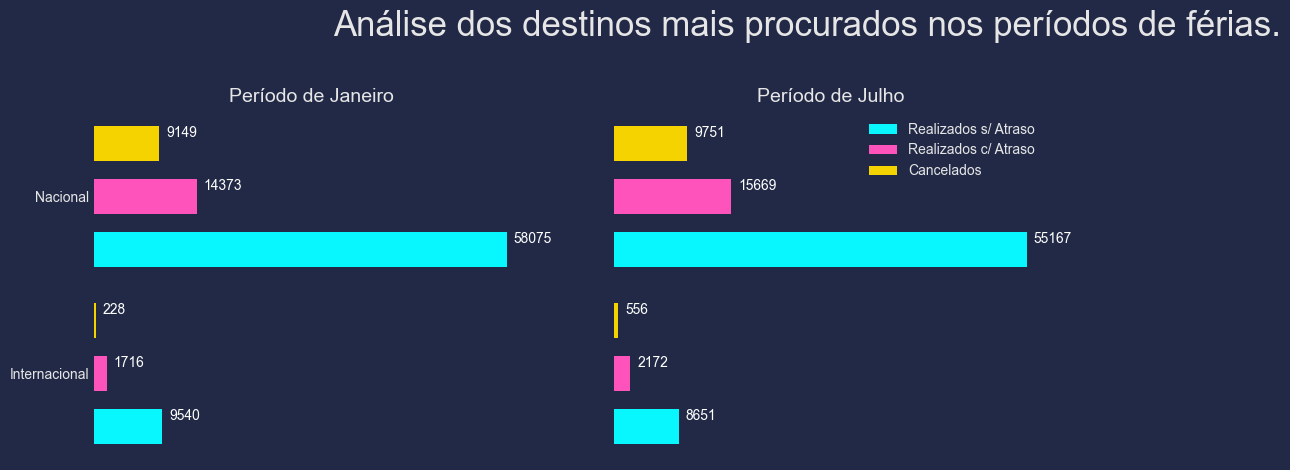

In [24]:
# Plot
Plot.periodo_ferias_geral(
    dataframe=voos_ferias_agg,
    periodo_ferias=AnacVoos.periodo_ferias(),
    grid=False,
    context='cyberpunk',
    figsize=(19, 10),
    suptitle='Análise dos destinos mais procurados nos períodos de férias.'
)

### 3.1.1 Principais destinos nacionais nos períodos de julho, dezembro e janeiro

In [25]:
# Dataframe
nacionais = list()
linha = 'Nacional'

for i, periodo in enumerate(AnacVoos.periodo_ferias()):
    nacionais.append(
        AnacVoos.get_voos_ferias_linha_periodo(
            cols_percentuais=[
                ['tx_realizados', 'realizados_s_atraso'],
                ['tx_atrasos', 'realizados_c_atraso'],
                ['tx_cancelados', 'cancelados']],
            cols_groupyby=['codigo_tipo_linha', 'periodo_ferias', 'rota'],
            linha=linha, 
            periodo=periodo,
            round=3
            )
        )
    print(f"10 Principais rotas nacionais no período de {periodo.title()}")
    display(nacionais[i])
    print()

nacionais: pd.DataFrame = pd.concat(nacionais)

10 Principais rotas nacionais no período de Janeiro


,codigo_tipo_linha,periodo_ferias,rota,distancia_media_km,voos,realizados_s_atraso,tx_realizados,realizados_c_atraso,tx_atrasos,cancelados,tx_cancelados
0,Nacional,janeiro,SP - RJ,374.458921,2707,1974,0.729,523,0.193,210,0.078
1,Nacional,janeiro,RJ - SP,375.116650,2596,1777,0.685,614,0.237,205,0.079
2,Nacional,janeiro,SP - MG,490.929679,2578,1634,0.634,446,0.173,498,0.193
3,Nacional,janeiro,MG - SP,491.209767,2575,1712,0.665,350,0.136,513,0.199
4,Nacional,janeiro,SP - SP,314.088906,2216,1576,0.711,333,0.150,307,0.139
5,Nacional,janeiro,SP - PR,455.160217,2127,1408,0.662,420,0.197,299,0.141
6,Nacional,janeiro,PR - SP,465.339864,2104,1488,0.707,320,0.152,296,0.141
7,Nacional,janeiro,SC - SP,482.230319,1723,1277,0.741,308,0.179,138,0.080
8,Nacional,janeiro,MG - MG,306.936759,1721,776,0.451,128,0.074,817,0.475
9,Nacional,janeiro,SP - RS,848.189938,1713,1276,0.745,275,0.161,162,0.095



10 Principais rotas nacionais no período de Julho


,codigo_tipo_linha,periodo_ferias,rota,distancia_media_km,voos,realizados_s_atraso,tx_realizados,realizados_c_atraso,tx_atrasos,cancelados,tx_cancelados
0,Nacional,julho,SP - RJ,373.091287,2708,1879,0.694,462,0.171,367,0.136
1,Nacional,julho,RJ - SP,373.706965,2588,1745,0.674,538,0.208,305,0.118
2,Nacional,julho,MG - SP,494.547083,2518,1614,0.641,501,0.199,403,0.160
3,Nacional,julho,SP - SP,322.000059,2506,1634,0.652,546,0.218,326,0.130
4,Nacional,julho,SP - MG,494.560450,2498,1685,0.675,448,0.179,365,0.146
5,Nacional,julho,SP - PR,474.707511,2125,1381,0.650,450,0.212,294,0.138
6,Nacional,julho,PR - SP,472.941298,2084,1374,0.659,470,0.226,240,0.115
7,Nacional,julho,SP - SC,481.361467,1808,1228,0.679,388,0.215,192,0.106
8,Nacional,julho,SC - SP,481.730059,1788,1255,0.702,363,0.203,170,0.095
9,Nacional,julho,SP - RS,848.184458,1728,1127,0.652,420,0.243,181,0.105



10 Principais rotas nacionais no período de Dezembro


,codigo_tipo_linha,periodo_ferias,rota,distancia_media_km,voos,realizados_s_atraso,tx_realizados,realizados_c_atraso,tx_atrasos,cancelados,tx_cancelados
0,Nacional,dezembro,SP - RJ,373.274391,2609,1648,0.632,590,0.226,371,0.142
1,Nacional,dezembro,SP - SP,322.360059,2528,1576,0.623,523,0.207,429,0.170
2,Nacional,dezembro,RJ - SP,373.926522,2504,1502,0.600,641,0.256,361,0.144
3,Nacional,dezembro,MG - SP,491.035389,2501,1538,0.615,523,0.209,440,0.176
4,Nacional,dezembro,SP - MG,490.359770,2501,1534,0.613,501,0.200,466,0.186
5,Nacional,dezembro,SP - PR,469.060358,2375,1454,0.612,480,0.202,441,0.186
6,Nacional,dezembro,PR - SP,478.489815,2238,1466,0.655,430,0.192,342,0.153
7,Nacional,dezembro,SP - SC,477.883881,1896,1334,0.704,390,0.206,172,0.091
8,Nacional,dezembro,SC - SP,477.391461,1895,1428,0.754,293,0.155,174,0.092
9,Nacional,dezembro,SP - RS,850.161104,1633,1107,0.678,332,0.203,194,0.119


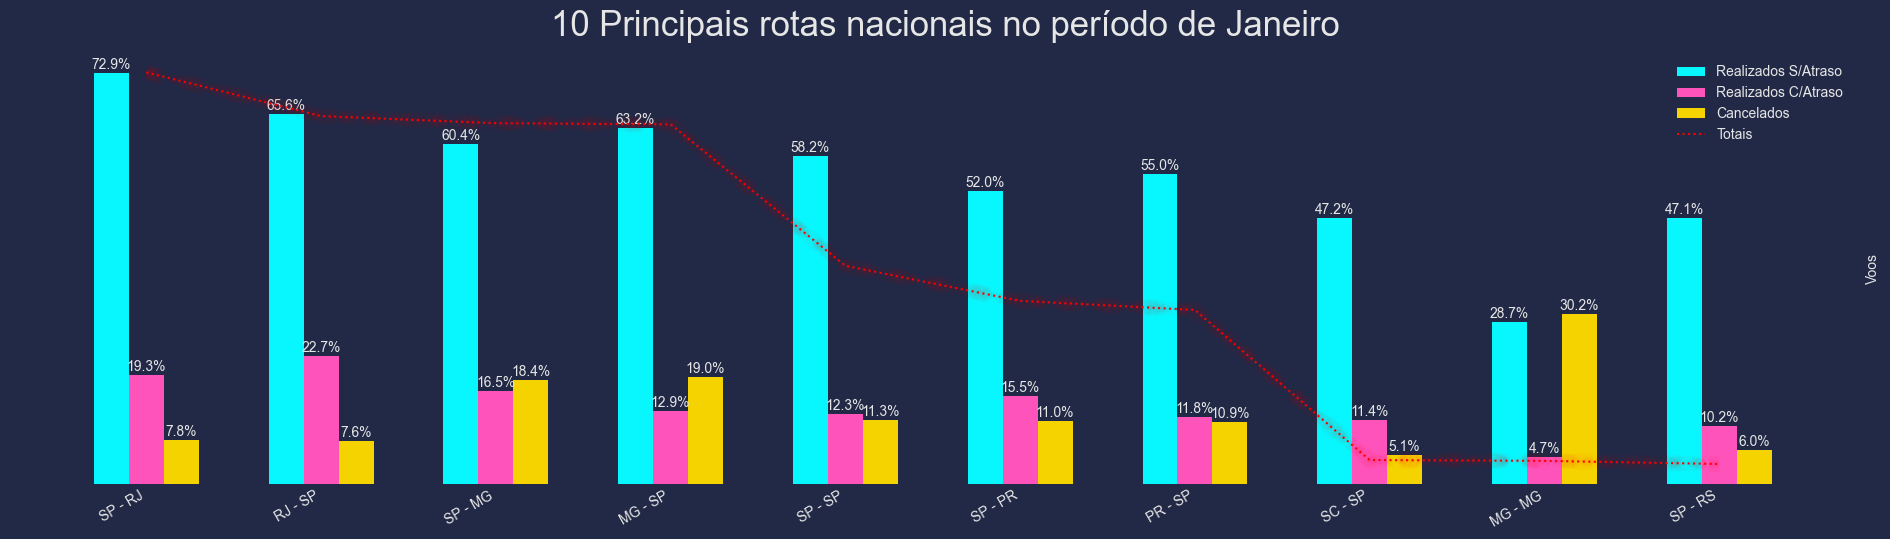

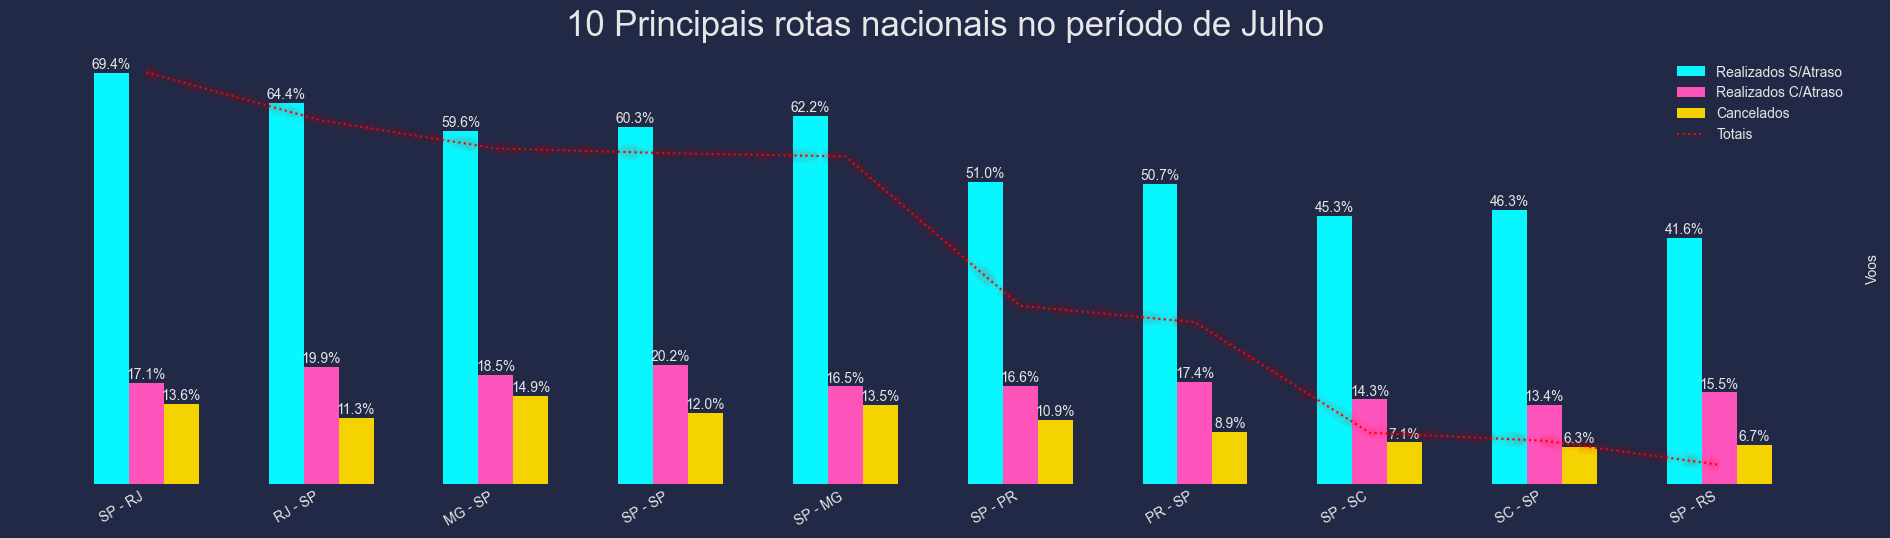

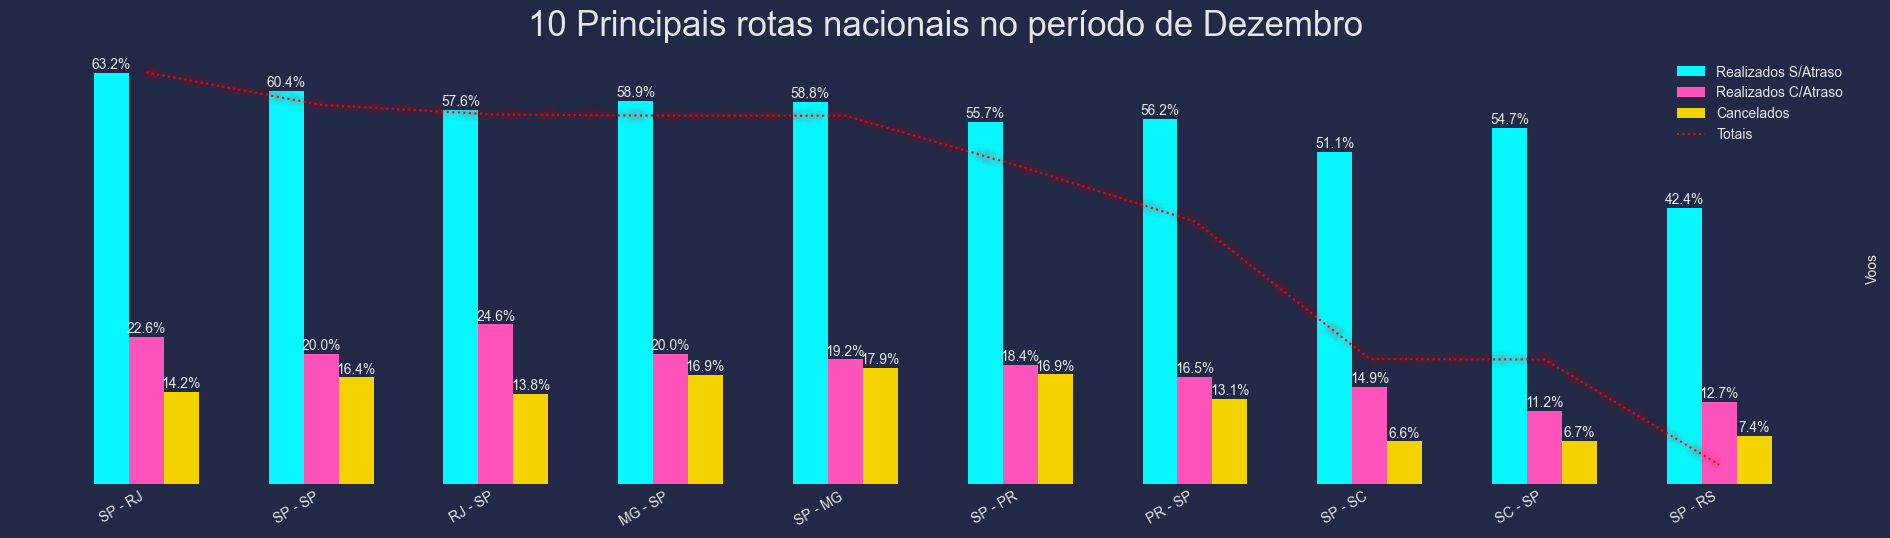

In [26]:
# Plot
for periodo in AnacVoos.periodo_ferias():
    Plot.periodo_ferias_tipo_linha(
        dataframe=nacionais.query("periodo_ferias == @periodo"),
        periodo_ferias=periodo,
        grid=False,
        context='cyberpunk',
        figsize=(19, 10),
        suptitle=f"10 Principais rotas nacionais no período de {periodo.title()}"
    )

### 3.1.2. Principais destinos internacionais nos períodos de julho, dezembro e janeiro

In [27]:
# Dataframe
internacionais = list()
linha = 'Internacional'

for i, periodo in enumerate(AnacVoos.periodo_ferias()):
    internacionais.append(
        AnacVoos.get_voos_ferias_linha_periodo(
            cols_percentuais=[
                ['tx_realizados', 'realizados_s_atraso'],
                ['tx_atrasos', 'realizados_c_atraso'],
                ['tx_cancelados', 'cancelados']],
            cols_groupyby=['codigo_tipo_linha', 'periodo_ferias', 'rota'],
            linha=linha, 
            periodo=periodo,
            round=3
            )
        )
    print(f"10 Principais rotas internacionais no período de {periodo.title()}")
    display(internacionais[i])
    print()

internacionais: pd.DataFrame = pd.concat(internacionais)

10 Principais rotas internacionais no período de Janeiro


,codigo_tipo_linha,periodo_ferias,rota,distancia_media_km,voos,realizados_s_atraso,tx_realizados,realizados_c_atraso,tx_atrasos,cancelados,tx_cancelados
0,Internacional,janeiro,Estados Unidos - Brasil,7090.574461,1303,940,0.721,327,0.251,36,0.028
1,Internacional,janeiro,Brasil - Estados Unidos,7099.802539,1302,1081,0.830,196,0.151,25,0.019
2,Internacional,janeiro,Argentina - Brasil,1741.154345,1211,1108,0.915,81,0.067,22,0.018
3,Internacional,janeiro,Brasil - Argentina,1740.135592,1201,1063,0.885,116,0.097,22,0.018
4,Internacional,janeiro,Brasil - Panama,4874.583625,406,397,0.978,9,0.022,0,0.000
5,Internacional,janeiro,Panama - Brasil,4874.583625,406,385,0.948,15,0.037,6,0.015
6,Internacional,janeiro,Chile - Brasil,2758.119466,381,335,0.879,37,0.097,9,0.024
7,Internacional,janeiro,Brasil - Chile,2724.735142,371,306,0.825,64,0.173,1,0.003
8,Internacional,janeiro,Brasil - Portugal,7048.393230,321,264,0.822,55,0.171,2,0.006
9,Internacional,janeiro,Portugal - Brasil,7129.754497,310,241,0.777,66,0.213,3,0.010



10 Principais rotas internacionais no período de Julho


,codigo_tipo_linha,periodo_ferias,rota,distancia_media_km,voos,realizados_s_atraso,tx_realizados,realizados_c_atraso,tx_atrasos,cancelados,tx_cancelados
0,Internacional,julho,Estados Unidos - Brasil,7040.629260,1274,820,0.644,421,0.330,33,0.026
1,Internacional,julho,Brasil - Estados Unidos,7045.472000,1262,965,0.765,241,0.191,56,0.044
2,Internacional,julho,Brasil - Argentina,1816.740174,1223,919,0.751,214,0.175,90,0.074
3,Internacional,julho,Argentina - Brasil,1816.898332,1221,910,0.745,224,0.183,87,0.071
4,Internacional,julho,Brasil - Chile,2698.101675,426,366,0.859,59,0.138,1,0.002
5,Internacional,julho,Chile - Brasil,2698.298077,425,362,0.852,63,0.148,0,0.000
6,Internacional,julho,Brasil - Panama,4859.593208,394,363,0.921,17,0.043,14,0.036
7,Internacional,julho,Panama - Brasil,4861.769865,394,344,0.873,32,0.081,18,0.046
8,Internacional,julho,Brasil - Portugal,7158.423843,327,251,0.768,72,0.220,4,0.012
9,Internacional,julho,Portugal - Brasil,7197.108557,327,252,0.771,71,0.217,4,0.012



10 Principais rotas internacionais no período de Dezembro


,codigo_tipo_linha,periodo_ferias,rota,distancia_media_km,voos,realizados_s_atraso,tx_realizados,realizados_c_atraso,tx_atrasos,cancelados,tx_cancelados
0,Internacional,dezembro,Estados Unidos - Brasil,6994.696597,1229,842,0.685,329,0.268,58,0.047
1,Internacional,dezembro,Brasil - Estados Unidos,7009.009344,1222,1004,0.822,171,0.140,47,0.038
2,Internacional,dezembro,Brasil - Argentina,1798.812257,1127,884,0.784,193,0.171,50,0.044
3,Internacional,dezembro,Argentina - Brasil,1798.216187,1125,922,0.820,148,0.132,55,0.049
4,Internacional,dezembro,Brasil - Chile,2696.271628,430,368,0.856,54,0.126,8,0.019
5,Internacional,dezembro,Chile - Brasil,2696.963148,428,346,0.808,76,0.178,6,0.014
6,Internacional,dezembro,Brasil - Panama,4847.905193,370,353,0.954,9,0.024,8,0.022
7,Internacional,dezembro,Panama - Brasil,4847.905193,370,347,0.938,15,0.041,8,0.022
8,Internacional,dezembro,Brasil - Portugal,7050.567253,305,249,0.816,33,0.108,23,0.075
9,Internacional,dezembro,Portugal - Brasil,7092.521985,305,229,0.751,44,0.144,32,0.105


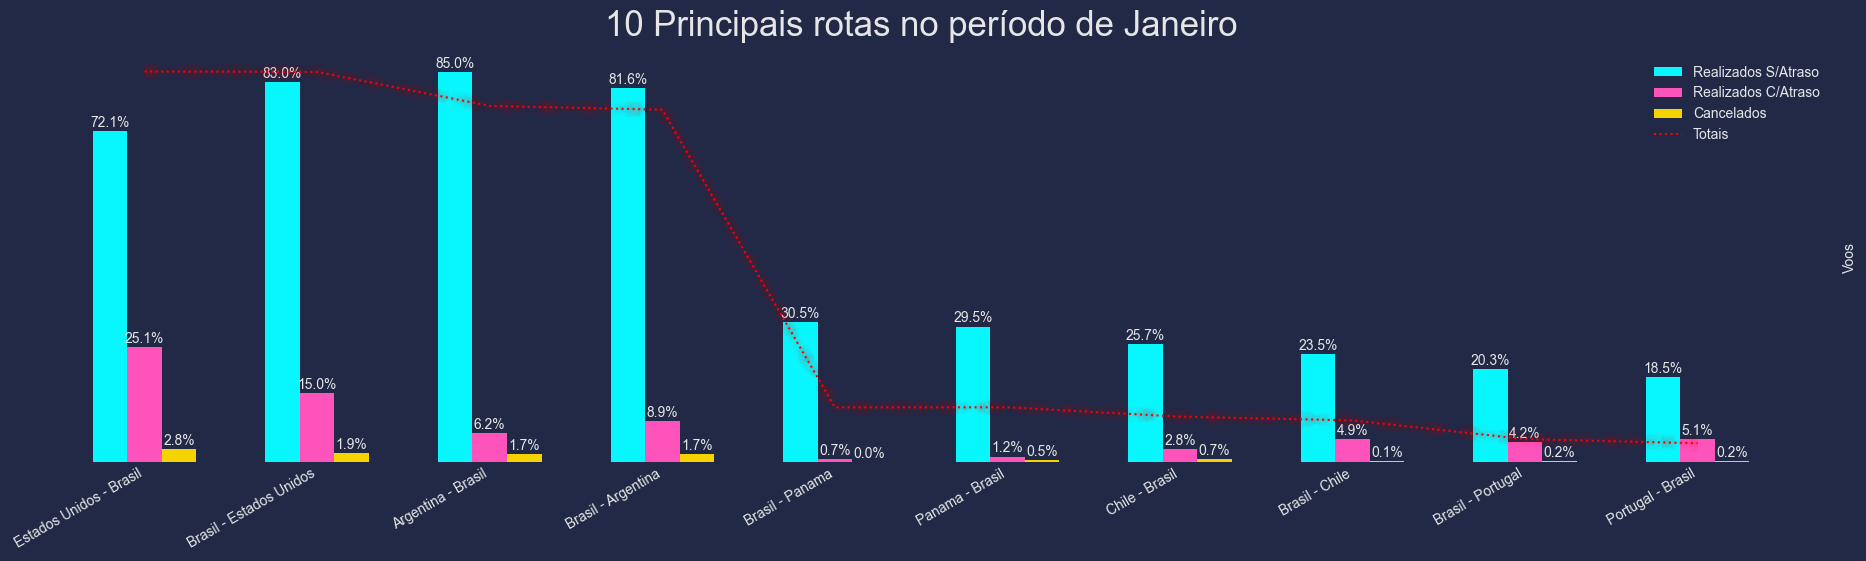

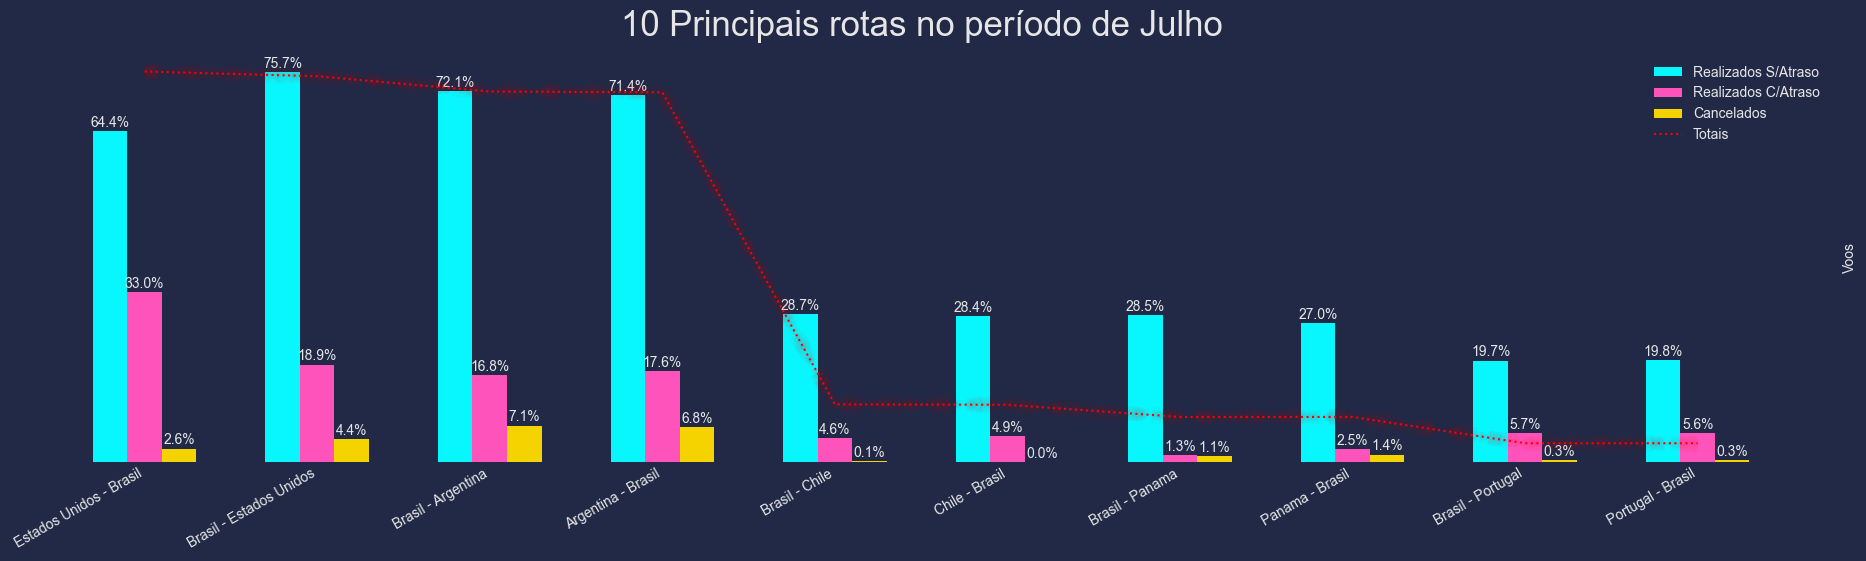

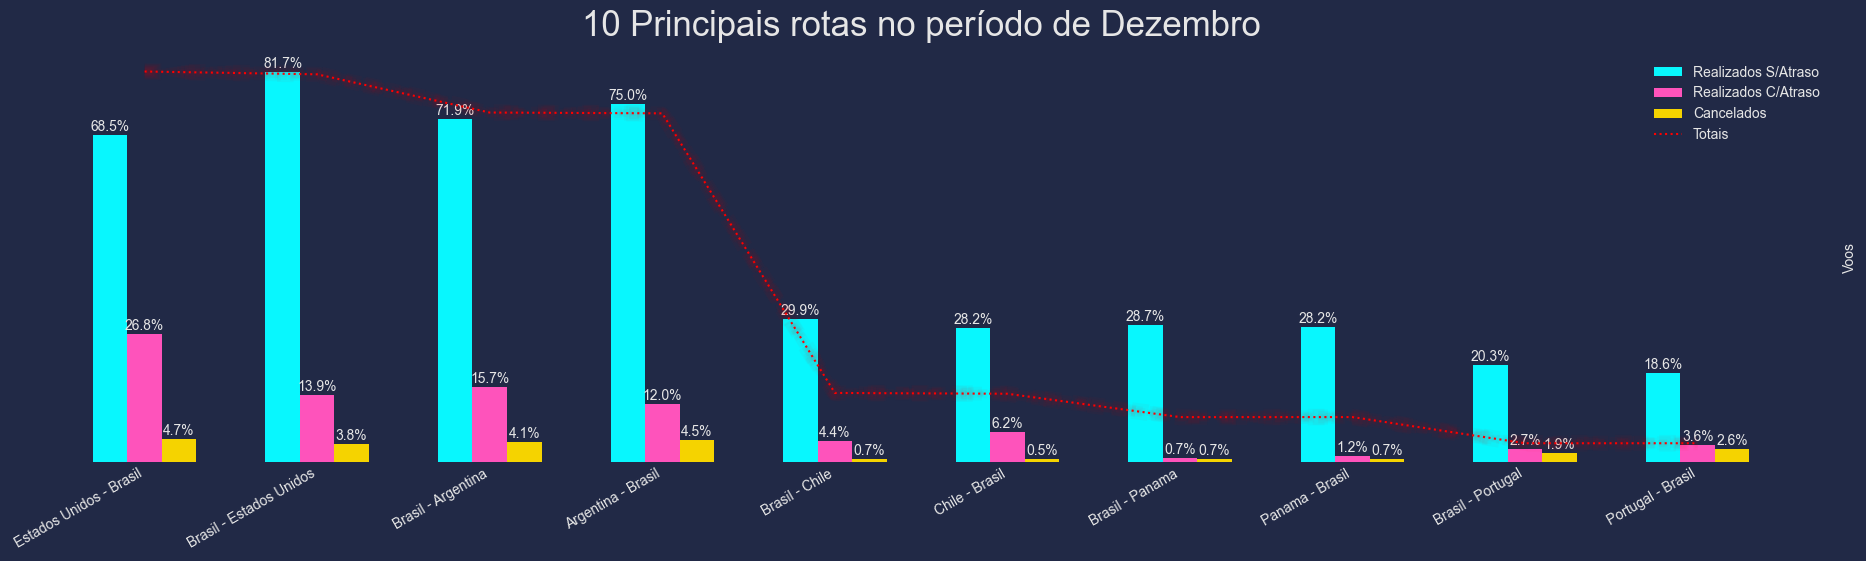

In [28]:
# Plot
for periodo in AnacVoos.periodo_ferias():
    Plot.periodo_ferias_tipo_linha(
        dataframe=internacionais.query("periodo_ferias == @periodo"),
        periodo_ferias=periodo,
        grid=False,
        context='cyberpunk',
        figsize=(19, 10),
        suptitle=f"10 Principais rotas no período de {periodo.title()}"
    )

## 3.2. Como ficam os aeroportos nesses meses?
Iremos analisar o aumento de atrasos, vôos cancelados, e os principais motivos, o dia mais provável de ter algum problema com o voo.

### 3.2.1. Atrasos

In [29]:
#Dataframe
atrasos = AnacVoos.get_atrasos_voos_ferias(
                cols_groupby=['periodo_ferias', 'codigo_tipo_linha', 'rota', 'justificativa_atraso'],
                converter_segundos_para_tempo=True,
            )

for periodo in AnacVoos.periodo_ferias():
    print(f"Ranking de justificativas de atraso em {periodo.title()}")
    
    for linha in AnacVoos.tipo_linha():
        display(atrasos.
            query("periodo_ferias == @periodo and codigo_tipo_linha == @linha").
            nlargest(10, 'total_atrasos').reset_index(drop=True)
            )

Ranking de justificativas de atraso em Janeiro


,periodo_ferias,codigo_tipo_linha,rota,justificativa_atraso,total_atrasos,media_atrasos_partida,media_atrasos_chegada
0,janeiro,Nacional,RJ - SP,Atraso não especificado,358,00:26:45,00:35:43
1,janeiro,Nacional,SP - RJ,Atraso não especificado,293,00:27:11,00:28:14
2,janeiro,Nacional,SP - MG,Atraso não especificado,227,00:32:07,00:32:24
3,janeiro,Nacional,SP - PR,Atraso não especificado,219,00:31:36,00:31:57
4,janeiro,Nacional,SP - SC,Atraso não especificado,180,00:31:32,00:30:40
5,janeiro,Nacional,SP - BA,Atraso não especificado,176,00:27:44,00:28:30
6,janeiro,Nacional,MG - SP,Atraso não especificado,171,00:20:15,00:27:58
7,janeiro,Nacional,SP - DF,Atraso não especificado,159,00:32:58,00:29:40
8,janeiro,Nacional,DF - SP,Atraso não especificado,155,00:20:07,00:33:25
9,janeiro,Nacional,PR - SP,Atraso não especificado,145,00:32:11,00:41:54


,periodo_ferias,codigo_tipo_linha,rota,justificativa_atraso,total_atrasos,media_atrasos_partida,media_atrasos_chegada
0,janeiro,Internacional,Estados Unidos - Brasil,Atraso não especificado,228,02:53:56,02:48:38
1,janeiro,Internacional,Brasil - Estados Unidos,Atraso não especificado,135,02:01:20,02:46:44
2,janeiro,Internacional,Estados Unidos - Brasil,Defeitos da aeronave,66,01:53:07,01:27:50
3,janeiro,Internacional,Peru - Brasil,Atraso não especificado,65,00:25:57,00:39:17
4,janeiro,Internacional,Brasil - Peru,Atraso não especificado,57,00:55:17,00:43:51
5,janeiro,Internacional,Brasil - Argentina,Atraso não especificado,55,01:11:29,01:07:48
6,janeiro,Internacional,Portugal - Brasil,Atraso não especificado,50,00:21:51,00:42:46
7,janeiro,Internacional,Brasil - Chile,Atraso não especificado,43,01:02:43,01:42:36
8,janeiro,Internacional,Colombia - Brasil,Atraso não especificado,40,00:14:33,00:26:22
9,janeiro,Internacional,Argentina - Brasil,Atraso não especificado,36,01:14:46,01:04:08


Ranking de justificativas de atraso em Julho


,periodo_ferias,codigo_tipo_linha,rota,justificativa_atraso,total_atrasos,media_atrasos_partida,media_atrasos_chegada
0,julho,Nacional,SP - SP,Atraso não especificado,285,00:25:09,00:30:42
1,julho,Nacional,SP - MG,Atraso não especificado,256,00:19:14,00:18:59
2,julho,Nacional,MG - SP,Atraso não especificado,253,00:18:29,00:22:09
3,julho,Nacional,SP - PR,Atraso não especificado,243,00:24:04,00:27:39
4,julho,Nacional,RJ - SP,Atraso não especificado,242,00:20:42,00:29:24
5,julho,Nacional,SP - RS,Atraso não especificado,218,00:26:12,00:30:37
6,julho,Nacional,SP - SC,Atraso não especificado,215,00:29:25,00:30:11
7,julho,Nacional,SP - RJ,Atraso não especificado,205,00:24:33,00:25:18
8,julho,Nacional,PR - SP,Atraso não especificado,192,00:28:46,00:31:08
9,julho,Nacional,SP - DF,Atraso não especificado,156,00:25:37,00:27:16


,periodo_ferias,codigo_tipo_linha,rota,justificativa_atraso,total_atrasos,media_atrasos_partida,media_atrasos_chegada
0,julho,Internacional,Estados Unidos - Brasil,Atraso não especificado,260,02:15:21,02:17:32
1,julho,Internacional,Brasil - Estados Unidos,Atraso não especificado,161,00:21:05,01:12:46
2,julho,Internacional,Brasil - Argentina,Atraso não especificado,146,01:13:56,01:06:28
3,julho,Internacional,Argentina - Brasil,Atraso não especificado,134,01:18:44,01:20:33
4,julho,Internacional,Estados Unidos - Brasil,Defeitos da aeronave,79,02:02:11,02:04:09
5,julho,Internacional,Brasil - Colombia,Atraso não especificado,72,00:25:44,00:35:31
6,julho,Internacional,Portugal - Brasil,Atraso não especificado,61,00:18:22,00:17:10
7,julho,Internacional,Italia - Brasil,Atraso não especificado,55,00:43:34,00:27:30
8,julho,Internacional,Brasil - Portugal,Atraso não especificado,49,00:11:17,00:11:03
9,julho,Internacional,Brasil - Peru,Atraso não especificado,46,00:19:09,00:23:13


Ranking de justificativas de atraso em Dezembro


,periodo_ferias,codigo_tipo_linha,rota,justificativa_atraso,total_atrasos,media_atrasos_partida,media_atrasos_chegada
0,dezembro,Nacional,SP - RJ,Atraso não especificado,319,00:23:43,00:25:08
1,dezembro,Nacional,RJ - SP,Atraso não especificado,282,00:22:57,00:28:46
2,dezembro,Nacional,SP - MG,Atraso não especificado,274,00:22:00,00:23:45
3,dezembro,Nacional,SP - SP,Atraso não especificado,245,00:22:08,00:24:04
4,dezembro,Nacional,SP - PR,Atraso não especificado,240,00:26:15,00:29:30
5,dezembro,Nacional,MG - SP,Atraso não especificado,224,00:18:37,00:22:33
6,dezembro,Nacional,SP - SC,Atraso não especificado,208,00:19:58,00:19:04
7,dezembro,Nacional,PR - SP,Atraso não especificado,199,00:19:22,00:27:20
8,dezembro,Nacional,SP - BA,Atraso não especificado,190,00:23:49,00:24:16
9,dezembro,Nacional,SP - RS,Atraso não especificado,175,00:18:53,00:16:47


,periodo_ferias,codigo_tipo_linha,rota,justificativa_atraso,total_atrasos,media_atrasos_partida,media_atrasos_chegada
0,dezembro,Internacional,Estados Unidos - Brasil,Atraso não especificado,203,01:38:58,01:26:41
1,dezembro,Internacional,Brasil - Argentina,Atraso não especificado,133,01:09:26,01:14:56
2,dezembro,Internacional,Argentina - Brasil,Atraso não especificado,90,03:26:13,03:12:20
3,dezembro,Internacional,Brasil - Estados Unidos,Atraso não especificado,89,01:12:55,01:35:46
4,dezembro,Internacional,Peru - Brasil,Atraso não especificado,66,00:20:55,00:33:11
5,dezembro,Internacional,Estados Unidos - Brasil,Defeitos da aeronave,60,01:29:35,01:17:12
6,dezembro,Internacional,Chile - Brasil,Atraso não especificado,49,02:11:58,02:12:24
7,dezembro,Internacional,Italia - Brasil,Atraso não especificado,46,00:15:57,00:07:01
8,dezembro,Internacional,Brasil - Peru,Atraso não especificado,43,00:18:30,00:10:43
9,dezembro,Internacional,Brasil - Colombia,Atraso não especificado,40,00:13:51,00:07:45


Ranking de justificativas de atraso em Janeiro


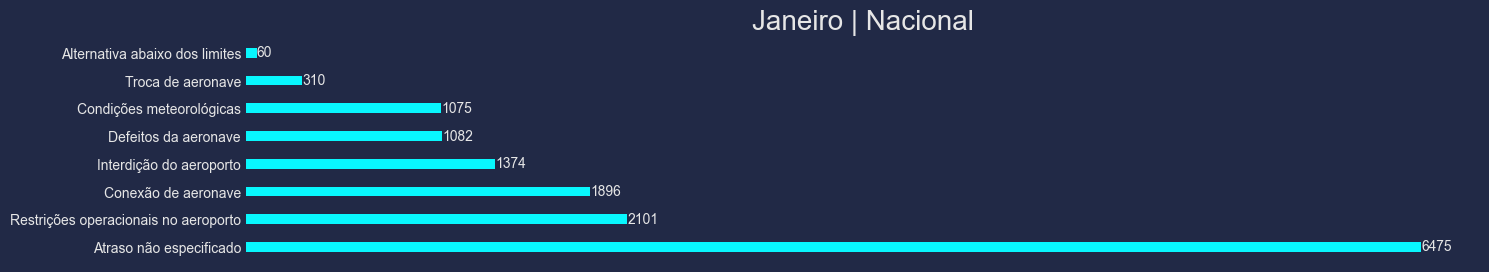

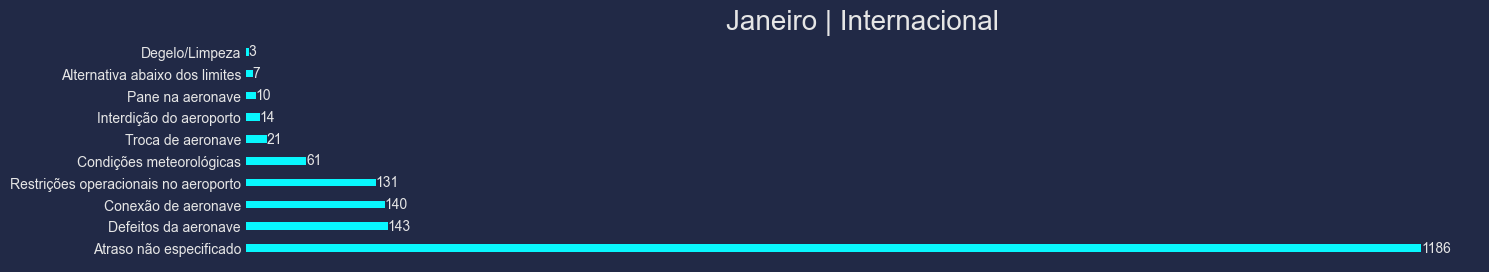

Ranking de justificativas de atraso em Julho


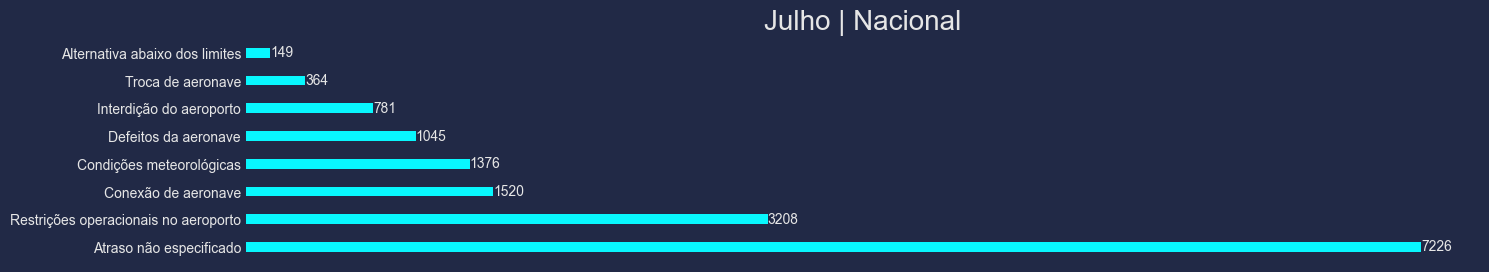

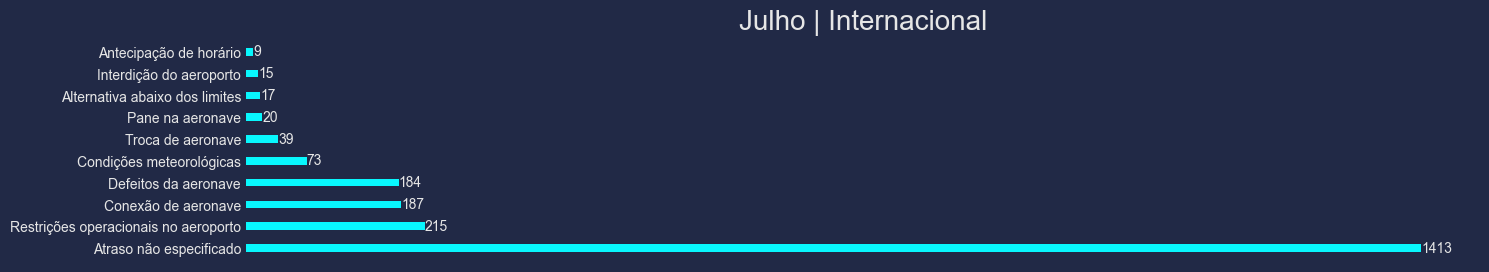

Ranking de justificativas de atraso em Dezembro


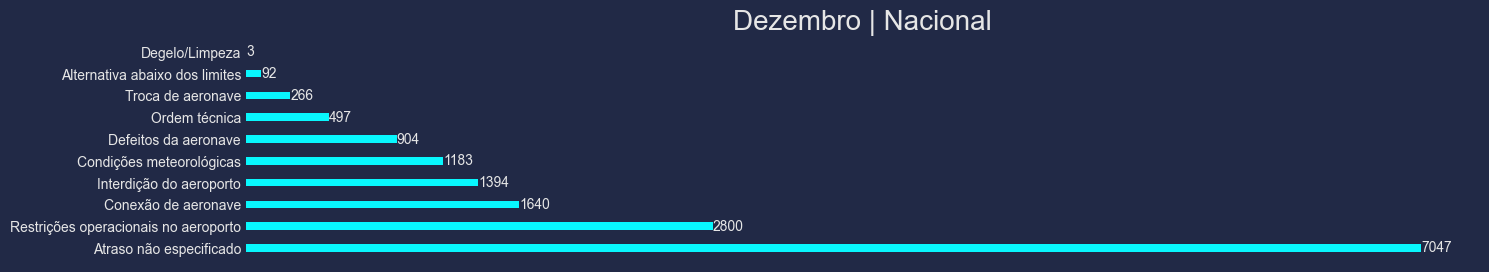

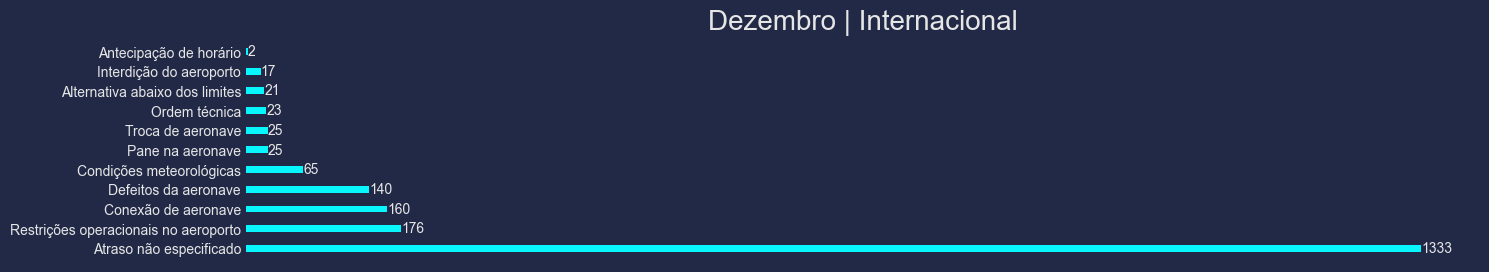

In [30]:
#Plot
for periodo in AnacVoos.periodo_ferias():
    print(f"Ranking de justificativas de atraso em {periodo.title()}")

    for linha in AnacVoos.tipo_linha():
        atrasos = AnacVoos.get_atrasos_voos_ferias(
            cols_groupby=['periodo_ferias', 'codigo_tipo_linha', 'justificativa_atraso'],
            converter_segundos_para_tempo=True,
            filtro_periodo_ferias=periodo,
            filtro_codigo_tipo_linha=linha,
        ).query("periodo_ferias == @periodo and codigo_tipo_linha == @linha")
        
        Plot.atrasos_periodo_ferias(
            dataframe=atrasos, 
            periodo=periodo, 
            linha=linha, 
            grid=False, 
            context='cyberpunk', 
            figsize=(15, 10))

### 3.2.2. Cancelamentos

In [31]:
#Dataframe
cancelamentos = AnacVoos.get_cancelamentos_voos_ferias(
                    cols_groupby=['periodo_ferias', 'codigo_tipo_linha', 'justificativa_cancelamento']
            )

for periodo in AnacVoos.periodo_ferias():
    print(f"Ranking de justificativas de atraso em {periodo.title()}")
    
    for linha in AnacVoos.tipo_linha():
        display(cancelamentos.
            query("periodo_ferias == @periodo and codigo_tipo_linha == @linha").
            nlargest(10, 'total_cancelamentos').reset_index(drop=True)
            )

Ranking de justificativas de atraso em Janeiro


,periodo_ferias,codigo_tipo_linha,justificativa_cancelamento,total_cancelamentos
0,janeiro,Nacional,Motivos técnicos-operacionais,7810
1,janeiro,Nacional,Cancelamento não especificado,614
2,janeiro,Nacional,Feriado nacional,378
3,janeiro,Nacional,Falta de passageiros com passagem marcada,266
4,janeiro,Nacional,Condições meteorológicas,59
5,janeiro,Nacional,Interdição do aeroporto,22


,periodo_ferias,codigo_tipo_linha,justificativa_cancelamento,total_cancelamentos
0,janeiro,Internacional,Motivos técnicos-operacionais,186
1,janeiro,Internacional,Cancelamento não especificado,34
2,janeiro,Internacional,Feriado nacional,7
3,janeiro,Internacional,Interdição do aeroporto,1


Ranking de justificativas de atraso em Julho


,periodo_ferias,codigo_tipo_linha,justificativa_cancelamento,total_cancelamentos
0,julho,Nacional,Motivos técnicos-operacionais,5196
1,julho,Nacional,Cancelamento não especificado,4003
2,julho,Nacional,Falta de passageiros com passagem marcada,377
3,julho,Nacional,Condições meteorológicas,142
4,julho,Nacional,Feriado nacional,24
5,julho,Nacional,Interdição do aeroporto,9


,periodo_ferias,codigo_tipo_linha,justificativa_cancelamento,total_cancelamentos
0,julho,Internacional,Motivos técnicos-operacionais,427
1,julho,Internacional,Cancelamento não especificado,84
2,julho,Internacional,Feriado nacional,44
3,julho,Internacional,Interdição do aeroporto,1


Ranking de justificativas de atraso em Dezembro


,periodo_ferias,codigo_tipo_linha,justificativa_cancelamento,total_cancelamentos
0,dezembro,Nacional,Cancelamento não especificado,5739
1,dezembro,Nacional,Motivos técnicos-operacionais,4323
2,dezembro,Nacional,Falta de passageiros com passagem marcada,679
3,dezembro,Nacional,Feriado nacional,191
4,dezembro,Nacional,Condições meteorológicas,110
5,dezembro,Nacional,Interdição do aeroporto,15


,periodo_ferias,codigo_tipo_linha,justificativa_cancelamento,total_cancelamentos
0,dezembro,Internacional,Cancelamento não especificado,293
1,dezembro,Internacional,Motivos técnicos-operacionais,237
2,dezembro,Internacional,Interdição do aeroporto,4
3,dezembro,Internacional,Condições meteorológicas,2
4,dezembro,Internacional,Feriado nacional,1


Ranking de justificativas de cancelamento em Janeiro


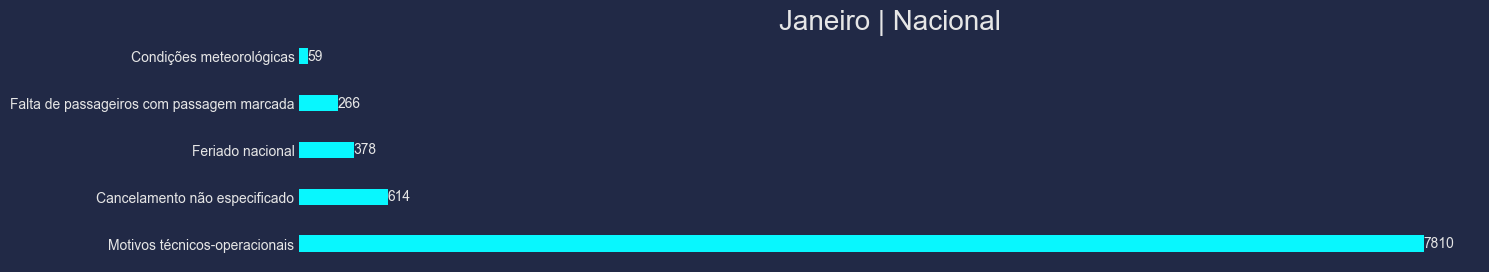

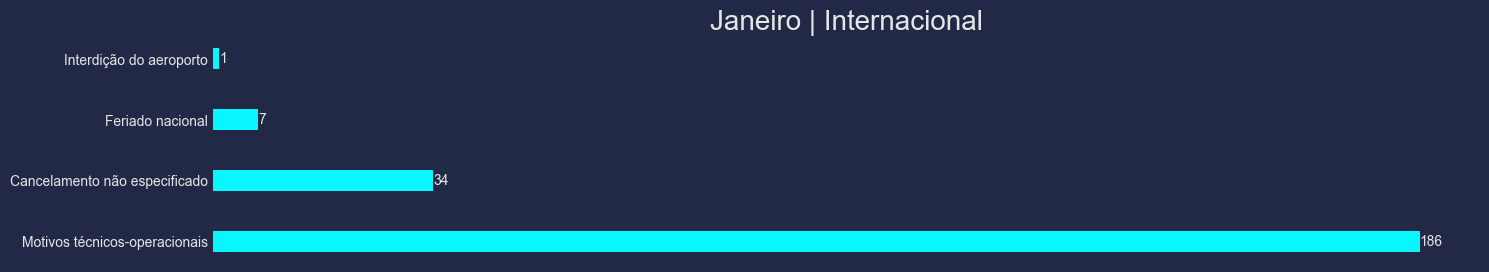

Ranking de justificativas de cancelamento em Julho


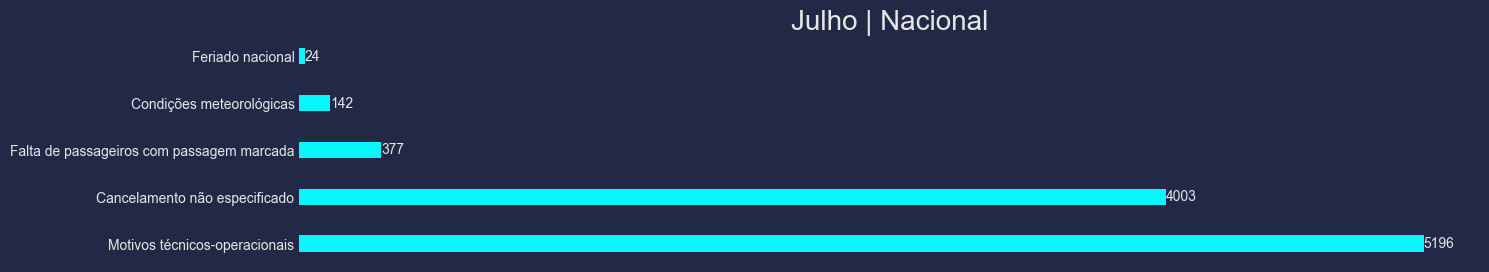

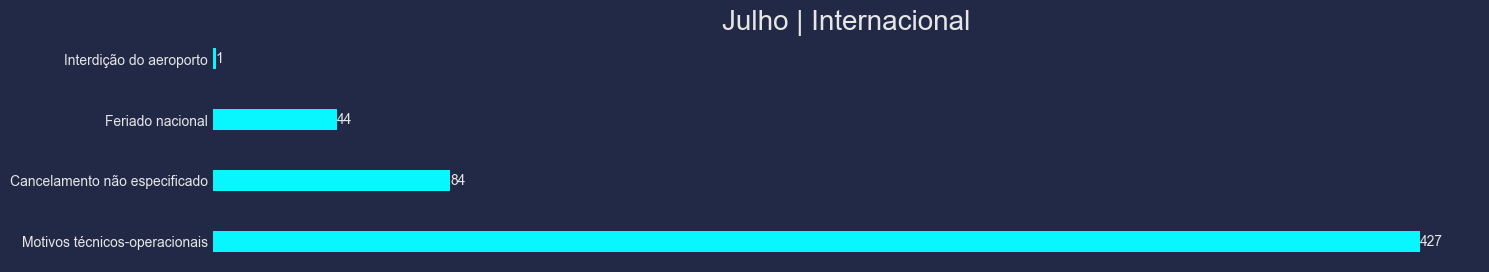

Ranking de justificativas de cancelamento em Dezembro


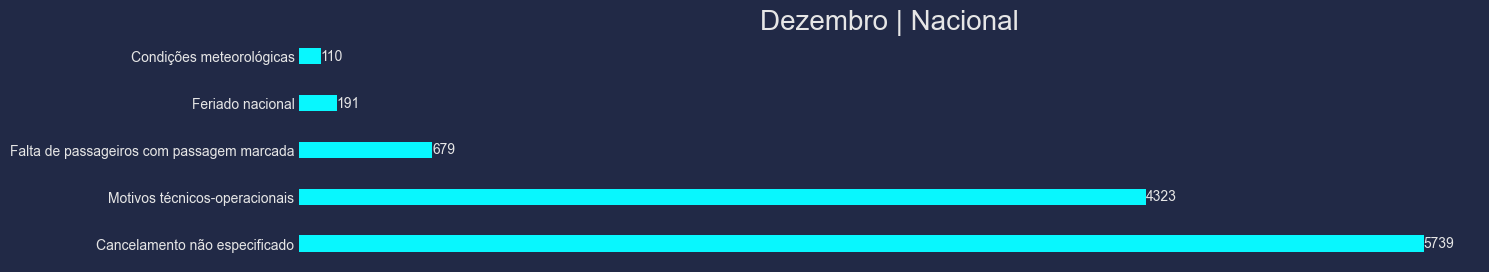

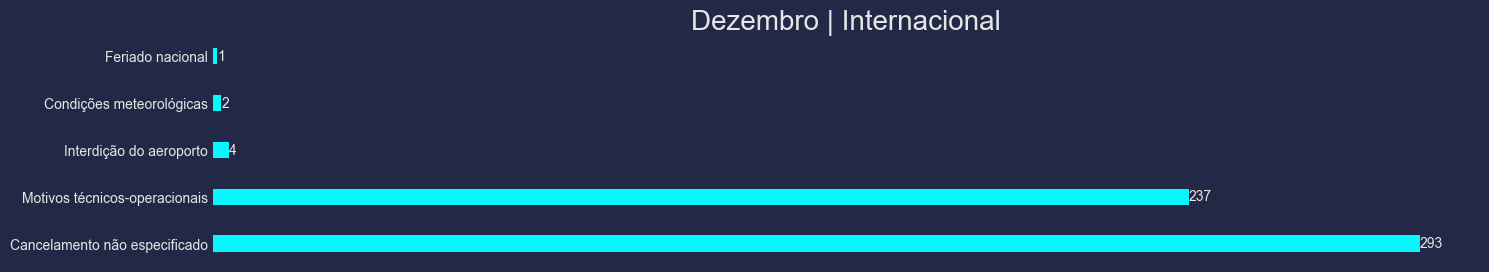

In [32]:
#Plot
for periodo in AnacVoos.periodo_ferias():
    print(f"Ranking de justificativas de cancelamento em {periodo.title()}")
    
    for linha in AnacVoos.tipo_linha():
        cancelamentos = AnacVoos.get_cancelamentos_voos_ferias(
            cols_groupby=['periodo_ferias', 'codigo_tipo_linha', 'justificativa_cancelamento']
        ).query("periodo_ferias == @periodo and codigo_tipo_linha == @linha").head(5)
        
        Plot.cancelamentos_periodo_ferias(
            dataframe=cancelamentos, 
            periodo=periodo, 
            linha=linha, 
            grid=False, 
            context='cyberpunk', 
            figsize=(15, 10))

## 3.3. Qual a melhor opção uma viagem nacional ou internacional?
Após as análises da questão 02, vamos analisar se existe algum favorecimento de vôos internacionais sobre os nacionais.

In [33]:
#Dataframe
resumo: pd.DataFrame = AnacVoos.get_voos_ferias_resumo(
    groupby_columns = ['codigo_tipo_linha', 'periodo_ferias'],
    txs_columns = [
        ['tx_realizados', 'realizados_s_atraso'],
        ['tx_atrasos', 'realizados_c_atraso'],
        ['tx_cancelados', 'cancelados']
    ],
    round=3
)

for linha in AnacVoos.tipo_linha():
    display(resumo.query("codigo_tipo_linha == @linha"))


,codigo_tipo_linha,periodo_ferias,voos,realizados_s_atraso,realizados_c_atraso,cancelados,tx_realizados,tx_atrasos,tx_cancelados
3,Nacional,dezembro,80996,54113,15826,11057,0.668,0.195,0.137
4,Nacional,janeiro,81597,58075,14373,9149,0.712,0.176,0.112
5,Nacional,julho,80587,55167,15669,9751,0.685,0.194,0.121


,codigo_tipo_linha,periodo_ferias,voos,realizados_s_atraso,realizados_c_atraso,cancelados,tx_realizados,tx_atrasos,tx_cancelados
0,Internacional,dezembro,11125,8601,1987,537,0.773,0.179,0.048
1,Internacional,janeiro,11484,9540,1716,228,0.831,0.149,0.020
2,Internacional,julho,11379,8651,2172,556,0.760,0.191,0.049


## 3.4. Qual a melhor rota?
Aqui faremos o DE-PARA entre os  aeroporto origem/destino, para os principais destinos, levantados na pergunta 01.

In [34]:
# Dataframe Internacional
voos_ferias = AnacVoos.get_voos_ferias()

internacionais = voos_ferias[voos_ferias['codigo_tipo_linha'] == 'Internacional']\
    .groupby(['periodo_ferias', 'rota']).size()\
    .reset_index(name='voos')

nacionais = voos_ferias[voos_ferias['codigo_tipo_linha'] == 'Nacional']\
    .groupby(['periodo_ferias', 'rota']).size()\
    .reset_index(name='voos')

for periodo in AnacVoos.periodo_ferias():
    internacionais_periodo = internacionais.query("periodo_ferias == @periodo")
    nacionais_periodo = nacionais.query("periodo_ferias == @periodo")

    top_internacionais = internacionais_periodo.nlargest(1, 'voos')
    top_nacionais = nacionais_periodo.nlargest(1, 'voos')

    print(f"Comparando os destinos mais procurados no período de {periodo}:")

    if not top_internacionais.empty and not top_nacionais.empty:
        if top_internacionais['voos'].values[0] > top_nacionais['voos'].values[0]:
            print(
                "O destino internacional mais procurado supera o destino nacional mais procurado.")
        elif top_internacionais['voos'].values[0] < top_nacionais['voos'].values[0]:
            print(
                "O destino nacional mais procurado supera o destino internacional mais procurado.")
        else:
            print(
                "O destino internacional e o destino nacional mais procurados têm a mesma quantidade de voos.")

        print("Destino internacional mais procurado:")
        display(top_internacionais.reset_index(drop=True))

        print("Destino nacional mais procurado:")
        display(top_nacionais.reset_index(drop=True))
    elif not top_internacionais.empty:
        print("Não foram encontrados destinos nacionais mais procurados neste período.")

        print("Destino internacional mais procurado:")
        display(top_internacionais.reset_index(drop=True))
    elif not top_nacionais.empty:
        print(
            "Não foram encontrados destinos internacionais mais procurados neste período.")

        print("Destino nacional mais procurado:")
        display(top_nacionais.reset_index(drop=True))
    else:
        print("Não foram encontrados destinos internacionais nem nacionais mais procurados neste período.")

    print()

Comparando os destinos mais procurados no período de janeiro:
O destino nacional mais procurado supera o destino internacional mais procurado.
Destino internacional mais procurado:


,periodo_ferias,aeroporto_destino,voos
0,janeiro,Guarulhos - Governador Andre Franco Montoro,3270


Destino nacional mais procurado:


,periodo_ferias,aeroporto_destino,voos
0,janeiro,Guarulhos - Governador Andre Franco Montoro,9144



Comparando os destinos mais procurados no período de julho:
O destino nacional mais procurado supera o destino internacional mais procurado.
Destino internacional mais procurado:


,periodo_ferias,aeroporto_destino,voos
0,julho,Guarulhos - Governador Andre Franco Montoro,3267


Destino nacional mais procurado:


,periodo_ferias,aeroporto_destino,voos
0,julho,Guarulhos - Governador Andre Franco Montoro,9203



Comparando os destinos mais procurados no período de dezembro:
O destino nacional mais procurado supera o destino internacional mais procurado.
Destino internacional mais procurado:


,periodo_ferias,aeroporto_destino,voos
0,dezembro,Guarulhos - Governador Andre Franco Montoro,3237


Destino nacional mais procurado:


,periodo_ferias,aeroporto_destino,voos
0,dezembro,Guarulhos - Governador Andre Franco Montoro,9335


## 3.5. Qual melhor dia da semana para pegar um vôo?
Iremos cruzar as informações de cancelamentos e atrasados com os dias da semana e verificar qual o dia tem uma menor probabilidade de ter algum problema.

In [35]:
# Dataframe
atrasos = voos_ferias\
    .query("partida_atrasou == 'N' and chegada_atrasou == 'N' and situacao_voo != 'Cancelado'")\
    .groupby(['codigo_tipo_linha', 'periodo_ferias', 'rota', 'aeroporto_origem', 'aeroporto_destino', 'dia_semana'])\
    .size().reset_index(name='qtd_atraso')\
    .sort_values('qtd_atraso', ascending=False)

for periodo in AnacVoos.periodo_ferias():
    for linha in AnacVoos.tipo_linha():
        print(f"\n\nVoo {linha} em {periodo.title()}:")
        display(atrasos.query("periodo_ferias == @periodo and codigo_tipo_linha == @linha").head(10).reset_index(drop=True))

# Atualizando tempo do processo
AnacVoos.tempo_execucao = (time.time() - AnacVoos.tempo_execucao)



Voo Nacional em Janeiro:


,codigo_tipo_linha,periodo_ferias,rota,aeroporto_origem,aeroporto_destino,dia_semana,qtd_atraso
0,Nacional,janeiro,BA - SP,Deputado Luis Eduardo Magalhaes,Guarulhos - Governador Andre Franco Montoro,sexta-feira,105
1,Nacional,janeiro,MG - SP,Tancredo Neves,Congonhas,sexta-feira,99
2,Nacional,janeiro,SP - BA,Guarulhos - Governador Andre Franco Montoro,Deputado Luis Eduardo Magalhaes,sábado,99
3,Nacional,janeiro,SP - BA,Guarulhos - Governador Andre Franco Montoro,Deputado Luis Eduardo Magalhaes,sexta-feira,98
4,Nacional,janeiro,SP - MG,Congonhas,Tancredo Neves,sexta-feira,98
5,Nacional,janeiro,SP - RS,Guarulhos - Governador Andre Franco Montoro,Salgado Filho,sábado,93
6,Nacional,janeiro,RS - SP,Salgado Filho,Guarulhos - Governador Andre Franco Montoro,sexta-feira,90
7,Nacional,janeiro,RJ - DF,Santos Dumont,Presidente Juscelino Kubitschek,sexta-feira,90
8,Nacional,janeiro,DF - RJ,Presidente Juscelino Kubitschek,Santos Dumont,sexta-feira,90
9,Nacional,janeiro,SP - RS,Guarulhos - Governador Andre Franco Montoro,Salgado Filho,sexta-feira,89




Voo Internacional em Janeiro:


,codigo_tipo_linha,periodo_ferias,rota,aeroporto_origem,aeroporto_destino,dia_semana,qtd_atraso
0,Internacional,janeiro,Brasil - Argentina,Guarulhos - Governador Andre Franco Montoro,Buenos Aires/Aeroparque,sábado,45
1,Internacional,janeiro,Argentina - Brasil,Buenos Aires/Aeroparque,Guarulhos - Governador Andre Franco Montoro,sábado,44
2,Internacional,janeiro,Chile - Brasil,Santiago Do Chile,Guarulhos - Governador Andre Franco Montoro,sexta-feira,43
3,Internacional,janeiro,Brasil - Argentina,Guarulhos - Governador Andre Franco Montoro,Buenos Aires/Aeroparque,quinta-feira,43
4,Internacional,janeiro,Argentina - Brasil,Buenos Aires/Aeroparque,Guarulhos - Governador Andre Franco Montoro,quinta-feira,43
5,Internacional,janeiro,Chile - Brasil,Santiago Do Chile,Guarulhos - Governador Andre Franco Montoro,quinta-feira,42
6,Internacional,janeiro,Brasil - Argentina,Guarulhos - Governador Andre Franco Montoro,Buenos Aires/Aeroparque,sexta-feira,42
7,Internacional,janeiro,Argentina - Brasil,Buenos Aires/Aeroparque,Guarulhos - Governador Andre Franco Montoro,sexta-feira,40
8,Internacional,janeiro,Brasil - Argentina,Guarulhos - Governador Andre Franco Montoro,Buenos Aires/Aeroparque,domingo,38
9,Internacional,janeiro,Brasil - Chile,Guarulhos - Governador Andre Franco Montoro,Santiago Do Chile,sábado,38




Voo Nacional em Julho:


,codigo_tipo_linha,periodo_ferias,rota,aeroporto_origem,aeroporto_destino,dia_semana,qtd_atraso
0,Nacional,julho,SP - MG,Congonhas,Tancredo Neves,quarta-feira,116
1,Nacional,julho,MG - SP,Tancredo Neves,Congonhas,quarta-feira,110
2,Nacional,julho,SP - MG,Congonhas,Tancredo Neves,sexta-feira,97
3,Nacional,julho,SP - MG,Congonhas,Tancredo Neves,quinta-feira,96
4,Nacional,julho,SP - MG,Congonhas,Tancredo Neves,segunda-feira,93
5,Nacional,julho,BA - SP,Deputado Luis Eduardo Magalhaes,Guarulhos - Governador Andre Franco Montoro,sexta-feira,91
6,Nacional,julho,MG - SP,Tancredo Neves,Congonhas,sexta-feira,87
7,Nacional,julho,MG - SP,Tancredo Neves,Congonhas,quinta-feira,85
8,Nacional,julho,RS - SP,Salgado Filho,Guarulhos - Governador Andre Franco Montoro,quinta-feira,83
9,Nacional,julho,RS - SP,Salgado Filho,Guarulhos - Governador Andre Franco Montoro,quarta-feira,82




Voo Internacional em Julho:


,codigo_tipo_linha,periodo_ferias,rota,aeroporto_origem,aeroporto_destino,dia_semana,qtd_atraso
0,Internacional,julho,Brasil - Chile,Guarulhos - Governador Andre Franco Montoro,Santiago Do Chile,sexta-feira,48
1,Internacional,julho,Chile - Brasil,Santiago Do Chile,Guarulhos - Governador Andre Franco Montoro,sexta-feira,47
2,Internacional,julho,Chile - Brasil,Santiago Do Chile,Guarulhos - Governador Andre Franco Montoro,quinta-feira,46
3,Internacional,julho,Brasil - Argentina,Guarulhos - Governador Andre Franco Montoro,Buenos Aires/Aeroparque,quinta-feira,46
4,Internacional,julho,Brasil - Chile,Guarulhos - Governador Andre Franco Montoro,Santiago Do Chile,quinta-feira,45
5,Internacional,julho,Chile - Brasil,Santiago Do Chile,Guarulhos - Governador Andre Franco Montoro,quarta-feira,43
6,Internacional,julho,Brasil - Chile,Guarulhos - Governador Andre Franco Montoro,Santiago Do Chile,quarta-feira,43
7,Internacional,julho,Argentina - Brasil,Buenos Aires/Aeroparque,Guarulhos - Governador Andre Franco Montoro,quinta-feira,43
8,Internacional,julho,Brasil - Argentina,Guarulhos - Governador Andre Franco Montoro,Buenos Aires/Aeroparque,sexta-feira,41
9,Internacional,julho,Brasil - Argentina,Guarulhos - Governador Andre Franco Montoro,Buenos Aires,quinta-feira,39




Voo Nacional em Dezembro:


,codigo_tipo_linha,periodo_ferias,rota,aeroporto_origem,aeroporto_destino,dia_semana,qtd_atraso
0,Nacional,dezembro,SP - MG,Congonhas,Tancredo Neves,terça-feira,103
1,Nacional,dezembro,MG - SP,Tancredo Neves,Congonhas,terça-feira,98
2,Nacional,dezembro,SP - MG,Congonhas,Tancredo Neves,quarta-feira,92
3,Nacional,dezembro,BA - SP,Deputado Luis Eduardo Magalhaes,Guarulhos - Governador Andre Franco Montoro,terça-feira,91
4,Nacional,dezembro,SP - RS,Guarulhos - Governador Andre Franco Montoro,Salgado Filho,quarta-feira,89
5,Nacional,dezembro,MG - SP,Tancredo Neves,Congonhas,quarta-feira,89
6,Nacional,dezembro,BA - SP,Deputado Luis Eduardo Magalhaes,Guarulhos - Governador Andre Franco Montoro,quarta-feira,88
7,Nacional,dezembro,SP - MG,Congonhas,Tancredo Neves,quinta-feira,85
8,Nacional,dezembro,SP - MG,Congonhas,Tancredo Neves,segunda-feira,85
9,Nacional,dezembro,MG - SP,Tancredo Neves,Congonhas,segunda-feira,84




Voo Internacional em Dezembro:


,codigo_tipo_linha,periodo_ferias,rota,aeroporto_origem,aeroporto_destino,dia_semana,qtd_atraso
0,Internacional,dezembro,Brasil - Chile,Guarulhos - Governador Andre Franco Montoro,Santiago Do Chile,quarta-feira,47
1,Internacional,dezembro,Brasil - Chile,Guarulhos - Governador Andre Franco Montoro,Santiago Do Chile,terça-feira,45
2,Internacional,dezembro,Chile - Brasil,Santiago Do Chile,Guarulhos - Governador Andre Franco Montoro,terça-feira,43
3,Internacional,dezembro,Chile - Brasil,Santiago Do Chile,Guarulhos - Governador Andre Franco Montoro,quinta-feira,43
4,Internacional,dezembro,Brasil - Chile,Guarulhos - Governador Andre Franco Montoro,Santiago Do Chile,quinta-feira,43
5,Internacional,dezembro,Chile - Brasil,Santiago Do Chile,Guarulhos - Governador Andre Franco Montoro,quarta-feira,42
6,Internacional,dezembro,Brasil - Argentina,Guarulhos - Governador Andre Franco Montoro,Buenos Aires/Aeroparque,quinta-feira,39
7,Internacional,dezembro,Argentina - Brasil,Buenos Aires/Aeroparque,Guarulhos - Governador Andre Franco Montoro,quarta-feira,38
8,Internacional,dezembro,Brasil - Chile,Guarulhos - Governador Andre Franco Montoro,Santiago Do Chile,segunda-feira,37
9,Internacional,dezembro,Brasil - Chile,Guarulhos - Governador Andre Franco Montoro,Santiago Do Chile,domingo,37


## 4.1. Resumo da base:

In [36]:
print("Total de arquivos processados:", AnacVoos.total_arquivos)
print("Total de registros processados:", AnacVoos.total_registros)
print("Dados sólidos:", AnacVoos.dados_solidos)
print("Tempo de execução:", Utils.formatar_tempo_execucao(AnacVoos.tempo_execucao))

Total de arquivos processados: 93
Total de registros processados: 277168
Dados sólidos: True
Tempo de execução: 00:01:21
